In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv('data/kickstarter_projects.csv')

In [3]:
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


In [4]:
def prepare_data(dataframe):
    dataframe_new = dataframe.copy()
    # extract duration
    dataframe_new["Launched"] = pd.to_datetime(dataframe_new["Launched"])
    dataframe_new["Deadline"] = pd.to_datetime(dataframe_new["Deadline"])
    dataframe_new["Duration_days"] = (dataframe_new["Deadline"] - dataframe_new["Launched"]).dt.days
    # extract month / year
    dataframe_new["Month"] = dataframe_new["Launched"].dt.month
    # drop 'State' == 'Other' (Canceled, Suspended and Live)
    dataframe_new = dataframe_new.query("State == 'Successful' or State == 'Failed'")
    # drop specific categories (?)
    # dataframe_new = dataframe_new.query("Category != '...' and Category != '...'")
    # Combine 'Category' and 'Subcategory' (to not loose correlation)
    dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
    categories = ["Category", "Subcategory", "Country", "State", "Combined_category"]
    dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
        dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]].astype("category")
    # 0 < Goal < 100_000
    dataframe_new = dataframe_new.query("0 < Goal < 100_000")
    # Pledged > 0
    dataframe_new = dataframe_new.query("Pledged > 0")
    # implement Name: len
    dataframe_new["Name_length"] = dataframe_new["Name"].str.len()
    # dataframe_new['Name_word_count'] = dataframe_new['Name'].str.split().apply(len)

    # Years: 2012 - 2018
    dataframe_new = dataframe_new[dataframe_new["Launched"].dt.year >= 2012]
    
    dataframe_new = dataframe_new.drop(["ID", "Launched", "Deadline", "Category", "Subcategory"], axis=1)
    
    return dataframe_new

In [6]:
ks = prepare_data(df)

/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_14870/106689526.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_14870/106689526.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/zh/qpz0zgzn4vn8sz_sl9t4h7vr0000gn/T/ipykernel_14870/106689526.py:23: Settin

# Baseline Model

In [7]:
ks.head()

,Name,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_length
38084,Introspective,United States,4000,5116,37,Successful,15,1,Art - Art,13
38085,Student Doc about attending Sundance Film Fest...,United States,300,367,13,Successful,13,1,Film & Video - Documentary,50
38087,BOARDED project,United States,2345,3251,65,Successful,44,1,Art - Art,15
38088,THE CITY TROLL: a graphic novel,United States,2000,6311,202,Successful,37,1,Comics - Comics,31
38089,California Brewing Company: Bringing jobs & be...,United States,48000,1931,19,Failed,44,1,Food - Food,60


"Prediction = Goal_value * factor"

In [39]:
def calculate_factor(dataframe):
    # Calculate the mean of 'Goal' and 'Pledged' columns
    mean_goal = dataframe['Goal'].mean()
    mean_pledged = dataframe['Pledged'].mean()
    
    # Calculate the factor
    factor = mean_pledged / mean_goal
    
    return factor

# Example usage with a dataframe named 'ks'
factor = calculate_factor(ks)
print(factor)

def base_model(factor, X_test):
    return X_test["Goal"] * factor


factor_raw_df = calculate_factor(df)
print(factor_raw_df)


0.8364425046277322
0.19887309256779198


# Our Model 

In [8]:
list(ks.columns)

['Name',
 'Country',
 'Goal',
 'Pledged',
 'Backers',
 'State',
 'Duration_days',
 'Month',
 'Combined_category',
 'Name_length']

In [9]:
X = ks[[
    #'Name',
    'Country',
    'Goal',
    #'Pledged',
    'Backers',
    #'State',
    'Duration_days',
    'Month',
    'Combined_category',
    'Name_length'
    ]]
y = ks['Pledged']



In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [12]:
ks.shape

(251831, 10)

In [13]:
ks.describe()

,Goal,Pledged,Backers,Duration_days,Month,Name_length
count,251831.000000,2.518310e+05,251831.000000,251831.000000,251831.000000,251831.000000
mean,11580.932209,9.686784e+03,122.174276,31.607193,6.310339,34.468862
std,15774.421676,6.958468e+04,828.326125,10.956577,3.306440,15.760413
min,1.000000,1.000000e+00,0.000000,0.000000,1.000000,1.000000
25%,2000.000000,1.450000e+02,4.000000,29.000000,3.000000,21.000000
50%,5000.000000,1.221000e+03,22.000000,29.000000,6.000000,34.000000
75%,15000.000000,5.644000e+03,78.000000,33.000000,9.000000,49.000000
max,99999.000000,1.328523e+07,219382.000000,89.000000,12.000000,71.000000


# Pipeline

In [14]:
X_test.head()

,Country,Goal,Backers,Duration_days,Month,Combined_category,Name_length
51437,United States,3000,11,37,4,Music - Rock,26
57757,United States,2000,32,14,6,Film & Video - Webseries,38
348934,United States,300,7,35,6,Fashion - Fashion,12
193634,Australia,676,3,17,1,Food - Food,30
112456,United States,870,32,29,9,Art - Illustration,44


In [15]:
X_test.columns

Index(['Country', 'Goal', 'Backers', 'Duration_days', 'Month',
       'Combined_category', 'Name_length'],
      dtype='object')

## Baseline Model evaluation

In [49]:
base_y_pred = base_model(calculate_factor(pd.concat([X_train, y_train], axis=1)), X_test)
mean_squared_error(y_test, base_y_pred, squared=False)

82020.68507844946

## Our Model evaluation

In [28]:
ct_gb = ColumnTransformer([('ohe', OneHotEncoder(), ['Country', 'Combined_category', 'Month']),
                                         # ('bin', KBinsDiscretizer(), ['Family']),
                                         # ('goal', FunctionTransformer(log_transform), ['Goal']),
                                         # ('goal', pipeline_goal, ['Goal']),
                                         # ('pledged', pipeline_pledged, ['Pledged']),                                         
                                         # ('standard', MinMaxScaler(), ['Duration_days']),
                                         ], remainder='passthrough') #passtrough?

# remainder = everything not mentioned in the ColumnTransformer 
# `drop` = don't use them, `passthrough` - use them as they areX_train

In [29]:
pipeline_gb = Pipeline([
    ('preprocessor', ct_gb),
    ('regressor', GradientBoostingRegressor())
])

pipeline_gb.fit(X_train, y_train)

y_pred_gb = pipeline_gb.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
print(f'Root Mean Squared Error: {mse_gb}')

r2_gb = r2_score(y_test, y_pred_gb)
print(f'R2 Score for DT Model = {r2_gb}')


Root Mean Squared Error: 53021.910915106055
R2 Score for DT Model = 0.5892713002153509


In [30]:
import pickle
with open("models/decision_tree_4.pkl", "wb") as file:
    pickle.dump(pipeline_gb, file)

Text(0.5, 0, 'Target (Pledged)')

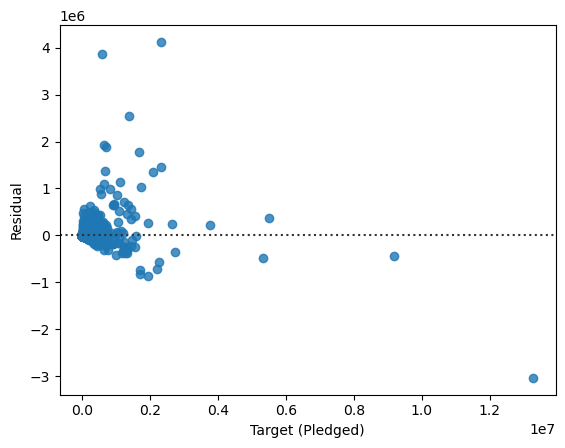

In [33]:
sns.residplot(x=y_test, y=y_pred_gb)
plt.ylabel('Residual')
plt.xlabel('Target (Pledged)')

In [34]:
pipeline_gb.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe', OneHotEncoder(),
                                    ['Country', 'Combined_category', 'Month'])])),
  ('regressor', GradientBoostingRegressor())],
 'verbose': False,
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(),
                                  ['Country', 'Combined_category', 'Month'])]),
 'regressor': GradientBoostingRegressor(),
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'passthrough',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor__transformers': [('ohe',
   OneHotEncoder(),
   ['Country', 'Combined_category', 'Month'])],
 'preprocessor__verbose': False,
 'preprocessor__verbose_feature_names_out': True,
 'preprocessor__ohe': OneHotEncoder(),
 'preprocessor__ohe__categories': 'auto',
 'preprocessor__ohe__drop': N

In [ ]:
params_dict = { 'regressor__criterion': ['friedman_mse', 'squared_error'],
                'regressor__loss': ['squared_error','absolute_error', 'huber', 'quantile'],
                'regressor__max_depth': [3, 5, 10],
                #'regressor__max_features': None,
                #'regressor__max_leaf_nodes': None,
                #'regressor__min_impurity_decrease': 0.0,
                #'regressor__min_samples_leaf': 1,
                #'regressor__min_samples_split': 2,
                #'regressor__min_weight_fraction_leaf': 0.0,
                'regressor__n_estimators': [50, 100, 200]
                #'regressor__n_iter_no_change': None,
                #'regressor__random_state': None,
                #'regressor__subsample': 1.0,
                #'regressor__tol': 0.0001,
                #'regressor__validation_fraction': 0.1,
                #'regressor__verbose': 0,
                #'regressor__warm_start': False
               }

In [ ]:
gridsearch = GridSearchCV(pipeline_gb, params_dict, cv=5, n_jobs=-1)

In [ ]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['Country',
                                                                          'Combined_category',
                                                                          'Month'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['friedman_mse',
                                                  'squared_error'],
                         'regressor__loss': ['squared_error', 'absolute_error',
                                             'huber', 'quantile'],
                         'regressor__max_depth': [3, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]})

In [ ]:
gridsearch.best_params_

{'regressor__criterion': 'friedman_mse',
 'regressor__loss': 'huber',
 'regressor__max_depth': 10,
 'regressor__n_estimators': 200}

In [ ]:
gridsearch.best_estimator_.score(X_test, y_test)

0.5997906269152637

In [ ]:
tuned_model = gridsearch.best_estimator_.fit(X_train, y_train)

y_pred_tm = tuned_model.predict(X_test)

mse_tm = mean_squared_error(y_test, y_pred_tm, squared=False)
print(f'Root Mean Squared Error: {mse_tm}')

r2_tm = r2_score(y_test, y_pred_tm)
print(f'R2 Score for GB Model = {r2_tm}')

Root Mean Squared Error: 52338.524901900244
R2 Score for DT Model = 0.5997906269152637


## Baseline Model evaluation

In [ ]:
base_y_pred = base_model(calculate_factor(pd.concat([X_train, y_train], axis=1)), X_test)
mean_squared_error(y_test, base_y_pred, squared=False)

82020.68507844946